<a href="https://colab.research.google.com/github/emilycalvert/greece_fire_economy_model/blob/main/greece_direct_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install earthengine-api
!pip install geemap
!pip install folium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.7/337.7 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 45.5 MB/s eta 0:00:00
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 1.8.0
    Uninstalling google-api-python-client-1.8.0:
      Successfully uninstalled google-api-python-client-1.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cloud-tpu-client 0.10 requires google-api-python-client==1.8.0, but you have google-api-python-client 2.125.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 10.0 MB

In [3]:
import ee
import geemap
import folium
import pandas as pd
import matplotlib.pyplot as plt

# **GEE Imagery**
### [FireCCI51: MODIS Fire_cci Burned Area Pixel Product, Version 5.1](https://developers.google.com/earth-engine/datasets/catalog/ESA_CCI_FireCCI_5_1)
### Greece '01-'19

In [4]:
ee.Authenticate(auth_mode="notebook")
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/cloud-platform%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=3mM517xq2N0xBwU2YeGqrDnVdcy2lpZ1R3EHpqp4VV0&tc=5Ko2TdtAjh3bGxfJCth3PZkL0b9Vdu4_Whtd69am4Eg&cc=HRtitIeAXXrJ426UJBXg1Kyd6abtcARiHpjVAG-txCo

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AeaYSHAIrU-JQHYAd-rMMFDEfYfL8OqQc8mBobNKc_dGfGO2UHugI54irxM

Successfully saved authorization token.


In [5]:
# Load the FAO GAUL 2015 Level 0 (countries) dataset.
countries = ee.FeatureCollection("FAO/GAUL/2015/level0")

# Filter for Greece using the country name.
greece = countries.filter(ee.Filter.eq('ADM0_NAME', 'Greece'))

# Get the geometry of Greece.
greece_geometry = greece.geometry()

In [6]:
# Function to add Earth Engine layers to a Folium map
def add_ee_layer(self, ee_object, vis_params, name):
    try:
        map_id_dict = ee.Image().paint(ee_object, 0, 3).getMapId(vis_params)
        folium.raster_layers.TileLayer(
            tiles=map_id_dict['tile_fetcher'].url_format,
            attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
            name=name,
            overlay=True,
            control=True
        ).add_to(self)
    except:
        print("Could not display {}".format(name))

# Add Earth Engine drawing method to the folium.Map object
folium.Map.add_ee_layer = add_ee_layer

# Create a map centered on Greece
map = folium.Map(location=[39.0742, 21.8243], zoom_start=6)

# Add the Greece geometry to the map
map.add_ee_layer(greece_geometry, {'palette': 'blue'}, 'Greece Boundary')

# Display the map
map

In [7]:
type(greece_geometry)

ee.geometry.Geometry

In [8]:
start_date = '2001-01-01'
end_date = '2022-12-31'

In [9]:
fire_dataset= ee.ImageCollection("ESA/CCI/FireCCI/5_1").filterBounds(greece_geometry).filterDate(start_date, end_date).map(lambda image: image.clip(greece_geometry))

In [10]:
image_list = fire_dataset.toList(fire_dataset.size())

In [11]:
def print_image_details(image_list):
    size = image_list.size().getInfo()
    print(f"Total images in the collection: {size}")

    for i in range(size):
        image = ee.Image(image_list.get(i))
        image_id = image.id().getInfo()
        date = image.date().format().getInfo()

        print(f"Image ID: {image_id}, Date: {date}")

print_image_details(image_list)

Total images in the collection: 240
Image ID: 2001_01_01, Date: 2001-01-01T00:00:00
Image ID: 2001_02_01, Date: 2001-02-01T00:00:00
Image ID: 2001_03_01, Date: 2001-03-01T00:00:00


KeyboardInterrupt: 

# **GFW Tree Cover & Forest Loss from Fire in Greece '01-'22**

[PROPORTION OF TREE COVER LOSS DUE TO FIRES IN GREECE](https://www.globalforestwatch.org/dashboards/country/GRC/?category=fires&location=WyJjb3VudHJ5IiwiR1JDIl0%3D)

In [13]:
proportion_admin_data = pd.read_csv('/content/proportion_admin_data.csv')
proportion_metadata = pd.read_csv('/content/proportion_metadata.csv')
regional_coverdata = pd.read_csv('/content/treecover_loss_from_fires_by_region__ha.csv')

In [14]:
proportion_metadata.head()

,title,Proportion of tree cover loss due to fires in Greece
0,threshold,30
1,start_year,2001
2,end_year,2022
3,date_downloaded,2024-04-08
4,metadata,https://api.resourcewatch.org/v1/gfw-metadata/...


In [15]:
proportion_admin_data.head()

,name,adm1__id
0,Aegean,1
1,Athos,2
2,Attica,3
3,Crete,4
4,Epirus and Western Macedonia,5


In [16]:
regional_coverdata.head()

,iso,umd_tree_cover_loss__year,umd_tree_cover_loss__ha,umd_tree_cover_loss_from_fires__ha
0,GRC,2001,12616.822022,6902.147463
1,GRC,2002,5126.049313,843.208919
2,GRC,2003,2562.535174,326.383335
3,GRC,2004,6813.690617,984.852960
4,GRC,2005,4180.682542,978.830776


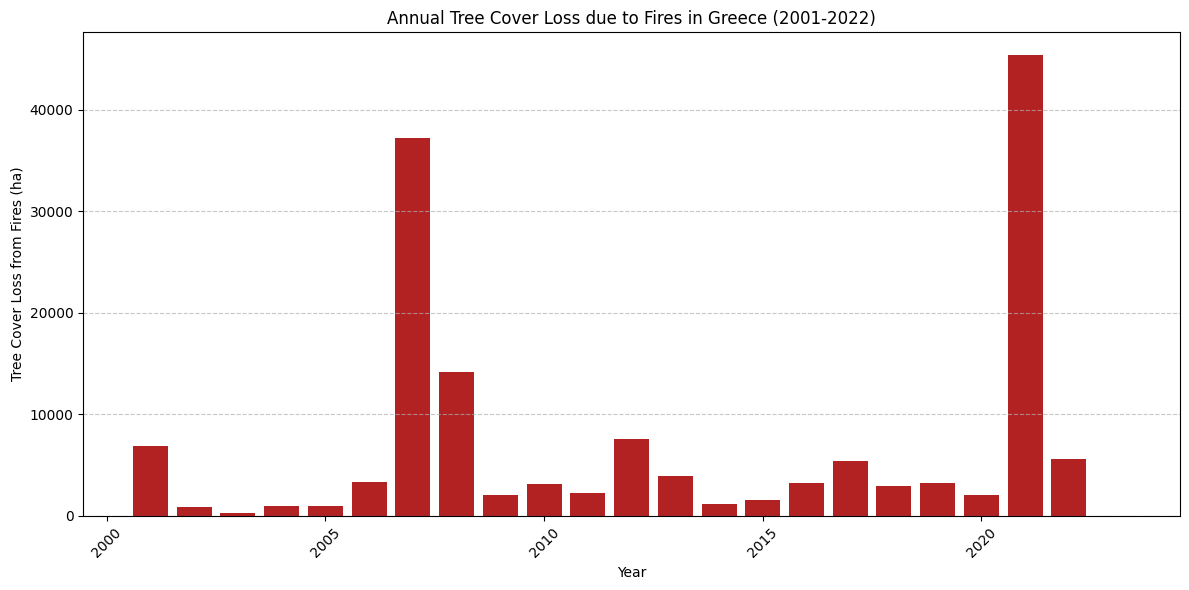

In [17]:
annual_loss = regional_coverdata.groupby('umd_tree_cover_loss__year')['umd_tree_cover_loss_from_fires__ha'].sum()

annual_loss_df = annual_loss.reset_index()

annual_loss_df.columns = ['Year', 'Total Tree Cover Loss from Fires (ha)']

plt.figure(figsize=(12, 6))
plt.bar(annual_loss_df['Year'], annual_loss_df['Total Tree Cover Loss from Fires (ha)'], color='firebrick')

plt.title('Annual Tree Cover Loss due to Fires in Greece (2001-2022)')
plt.xlabel('Year')
plt.ylabel('Tree Cover Loss from Fires (ha)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# **Greece Land Use & Cover**

[Copernicus Global Land Cover Layers: CGLS-LC100 Collection 3 | '15-'21](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_Landcover_100m_Proba-V-C3_Global)

In [18]:
landcover_image = ee.ImageCollection("COPERNICUS/Landcover/100m/Proba-V-C3/Global")\
    .filterBounds(greece_geometry)\
    .filterDate('2015-01-01', '2019-12-31')\
    .first()

In [19]:
forest_mask = landcover_image.select('forest_type').gte(1)\
                             .And(landcover_image.select('forest_type').lte(5))

In [20]:
masked_fire_dataset = fire_dataset.map(lambda image: image.updateMask(forest_mask))

In [21]:
first_image = masked_fire_dataset.first()

# Get the list of band names
band_names = first_image.bandNames()

# Print the list of band names
print('Band names:', band_names.getInfo())

Band names: ['BurnDate', 'ConfidenceLevel', 'LandCover', 'ObservedFlag']


Yearly Composites

In [22]:
def create_yearly_composite(year):
    start_date = ee.Date.fromYMD(year, 1, 1)
    end_date = start_date.advance(1, 'year')

    # Adjust to focus on the 'ConfidenceLevel' band
    yearly_composite = masked_fire_dataset.filterDate(start_date, end_date) \
                                          .select(['ConfidenceLevel']) \
                                          .reduce(ee.Reducer.mean())

    return yearly_composite

In [23]:
# Recreate composite_collection using the adjusted create_yearly_composite function
composite_collection = ee.ImageCollection([])
years = list(range(2002, 2020))
for year in years:
    composite = create_yearly_composite(year)
    composite_with_year = composite.addBands(ee.Image.constant(year).rename('year').toInt())
    composite_collection = composite_collection.merge(ee.ImageCollection([composite_with_year]))

In [24]:
# Adjust the visualization parameters
vis_params = {
    'bands': ['ConfidenceLevel_mean'],  # Adjusted to the mean of ConfidenceLevel
    'min': 0,  # Adjust minimum based on the scale of your confidence levels
    'max': 100,  # Assuming confidence levels are on a scale from 0 to 100
    'palette': ['yellow', 'red']  # From lower to higher confidence
}

In [25]:
composite_count = composite_collection.size().getInfo()
print('Number of images in the composite collection:', composite_count)

Number of images in the composite collection: 18


In [26]:
first_image_bands = composite_collection.first().bandNames().getInfo()
print('Bands in the composite images:', first_image_bands)

Bands in the composite images: ['ConfidenceLevel_mean', 'year']


In [27]:
def calculate_burned_area(image):
    # Use 'ConfidenceLevel_mean' to identify burned areas
    burned_area = image.select('ConfidenceLevel_mean').gt(0)  # Assuming confidence > 0 indicates burned

    # Calculate the area of burned pixels
    burned_area_pixel_count = burned_area.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=greece_geometry,
        scale=30,  # Adjust based on your data's resolution
        maxPixels=1e9
    )

    # Convert pixel count to area in hectares
    # Fix: Use the correct band ('ConfidenceLevel_mean') for the calculation
    burned_area_hectares = ee.Number(burned_area_pixel_count.get('ConfidenceLevel_mean')).multiply(900).divide(10000)

    return image.set('burned_area_hectares', burned_area_hectares)

In [28]:
composite_collection_with_burned_area = composite_collection.map(calculate_burned_area)


In [ ]:
first_year_burned_area = composite_collection_with_burned_area.first().get('burned_area_hectares').getInfo()
print(f"Burned area in hectares for 2002: {first_year_burned_area}")

Burned area in hectares for 2002: 4946888.075647058


# **Direct Losses: Values**

Above map confidence thresholds values and areas/heactares.

**Greek Economy '11-'21**
  * [Areas and production- Agriculture](https://www.statistics.gr/en/statistics/-/publication/SPG06/-)
  * [Agricultural Accounts](https://www.statistics.gr/en/statistics/-/publication/SEL42/-)
  * [Forest Products](https://ypen.gov.gr/perivallon/dasi/diacheirisi-dason/etisia-synoliki-paragogi-dasikon-proionton/)

**Greek Incidents & Emergency Response Efforts**
  * [Incidents](https://www.fireservice.gr/el_GR/synola-dedomenon)
  * [Credits](https://www.fireservice.gr/el_GR/synola-dedomenon)
  
[**Degredation Dynamics**](https://www.sciencedirect.com/science/article/abs/pii/S235293852400017X)

[**Carbon Stocks**](https://www.sciencedirect.com/science/article/pii/S0959378015000278)

**Biodiversity**
  * [Grouping of designation species according to their ecological requirements](https://ypen.gov.gr/perivallon/viopoikilotita/ektheseis-meletes/)
  * [Threat list of designation species](https://ypen.gov.gr/perivallon/viopoikilotita/ektheseis-meletes/)
  * [Proposed measures per species or group of designation species](https://ypen.gov.gr/perivallon/viopoikilotita/ektheseis-meletes/)
  * [Threat description sheets – measures per SPA](https://ypen.gov.gr/perivallon/viopoikilotita/ektheseis-meletes/)
  * [Guide to ecological requirements, threats and appropriate measures for designation species](https://ypen.gov.gr/perivallon/viopoikilotita/ektheseis-meletes/)
  * [National list of ZEP designation items](https://ypen.gov.gr/perivallon/viopoikilotita/ektheseis-meletes/)



# [**Insurance Losses '93-'18**](http://www1.eaee.gr/sites/default/files/oikmel_natcat_1993_2018_gr.pdf)

1. **Forest Fires (Greek: Δασικές πυρκαγιές):** A total of 1,542 incidents related to forest fires were recorded during this period.

2. **Total Damages Reported:** These incidents resulted in claims amounting to 45.8 million euros.

3. **Average Damage per Incident:** The average damage from each forest fire incident amounted to approximately 29,700 euros.

[Greece: Forest Fire Data '04 to Present | Yearly Publication](https://forest-fire.emergency.copernicus.eu/reports-and-publications/annual-fire-reports)

* GET DATASETS FROM MARIA AND CREDIT HER (Look at my sheet and the reports for data points.

# **CAMS global biomass burning emissions based on fire radiative power (GFAS)**
[A Copernicus Product](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-global-fire-emissions-gfas?tab=form)

# **European Forest Fire Information System Shapefile**
_The fires mapped in EFFIS may include fires set intentionally for the purpose of vegetation management._

### **MODIS Burnt Areas**
The Rapid Damage Assessment (RDA) module of EFFIS was initially implemented in 2003 to map burned areas during the fire season, by analyzing MODIS daily images at 250 m spatial resolution. For the monitoring of burned areas during the summer, daily images from the MODIS instruments on board of TERRA and AQUA satellites are acquired and processed few hours after the acquisition. The EFFIS Rapid Damage Assessment provides the daily update of the perimeters of burnt areas in Europe for fires of about 30 ha or larger twice, every day.

**IMPORTANT NOTE - For any use of the EFFIS Burnt Area product the conditions listed below must be taken into consideration:**

* The product is derived from the daily processing of MODIS satellite imagery at 250 m ground spatial resolution.
* The perimeters of the burned scars in the represent areas burned by fires as detected from MODIS satellite imagery. Therefore, no distinction is made between wildland fires, environmental burnings or prescribed fires.
* Burnt scars of approximately 30 hectares in size are mapped, although the product may also include the perimeters of burned areas of smaller dimension.
* Small burnt or un-burnt areas below the spatial resolution of the MODIS imagery are not mapped; these may include small unburned islands inside the burnt area perimeter.
* The Burnt Area product is updated up two times every day. The perimeter of burnt areas due to different fires happening between two sequential updates may be merged into a single perimeter.
* The dates reported as Start date and Last update may not correspond to the date of ignition and extinction of the fire
* The EFFIS burnt area product is intended to provide estimates of burnt areas at European level. Caution should be taken when comparing this product to other data that may have been produced using different methodologies and scopes.
* Although the burnt area perimeters are overlayed on the Google imagery, it must be noted that the original EFFIS product is produced at 250 m spatial resolution, not at the resolution of the underlying Google images.

Although only a fraction of the total number of fires is mapped, the area burned by fires of this size represents about 75% to 80% of the total area burned in EU. Modeling historical fire data from the EFFIS European fire database, equations have been set up for the different countries, which allow predicting the total area burned with good accuracy; that is, the total burnt area in a country is obtained as a function of the area burned by fires larger than 30 ha.

In order to obtain the statistics of the burnt area by land cover type, the data from the CORINE Land Cover database are used. Therefore the mapped burned areas are overlaid to land cover maps, allowing the assessment of damage that is harmonized for all the European Countries.

The burnt area mapping in the RDA is based on the identification of active large fires from the MODIS, the expansion of the burnt areas from these initial points on the basis of region-growing algorithms, and the refinement of the final perimeter of the fire through visual interpretation of the images. The process is aided by the systematic collection of fire news from the European media. An alternative to the current methodology is being developed. This method is based on abrupt post-fire vegetation change detected from MODIS daily time series. Once implemented, this method will allow for a better and less user-dependent classification of the burned areas.

1. Fix the Data Below- Narrow timeframe
2. Then do preliminary calculations with these methods:
      - [EU Method](https://effis-gwis-cms.s3.eu-west-1.amazonaws.com/effis/reports-and-publications/forest-focus-studies/FireDamagesJRC_Finale.pdf)
      - [NOAA Initial](https://www.ncei.noaa.gov/monitoring-content/billions/docs/smith-and-katz-2013.pdf)
      - [NOAA Updated](https://researchgate.net/publication/273895736_Quantifying_Uncertainty_and_Variable_Sensitivity_Within_the_US_Billion-Dollar_Weather_and_Climate_Disaster_Cost_Estimates)
3. Find the missing data for direct loss.
4. Read and understand all the data used and frameworks.
5. Confidence, Margins of Error, & Data Quality write-up and investigate.
6. Find data/possibilities for integrating indirect loss and start on that.
